# This notebook to download and compare results only from the best models

In [46]:
import wandb
import getpass
import os
import math

In [7]:
wandb_password = getpass.getpass("Enter your wandb password: ")
os.environ["WANDB_API_KEY"] = wandb_password

# Download results of best models individually using the run path link

In [167]:
import os
import wandb

# Log in to wandb
wandb.login()

# Specify the run path
run_path = input('Run path: ')

# Initialize the run object
api = wandb.Api()
run = api.run(run_path)

# Access run information
print("Run ID:", run.id)
print("Run Name:", run.name)

# Create directory with run name and identifier
directory = f"{run.name}_{run_path.split('/')[-1]}"
if not os.path.exists(directory):
    os.makedirs(directory)

# Access files
files = run.files()
for file in files:
    # Download the file
    file.download(replace=True, root=directory)
    # print("Downloaded:", file.name, "into", directory)

# get list of test losser 
test_losses = run.history().test_loss.tolist()
# finter list of test losses for each epoch
test_loss_epochs = [x for x in test_losses if not isinstance(x, float) or not math.isnan(x)]
# find best epoch index
best_epoch = test_loss_epochs.index(min(test_loss_epochs))
print(best_epoch)
# get list of results files
results_files = os.listdir(directory)
# iterate over files
for filename in results_files:
    if 'best' in filename:
         print('Already found best epoch')
         break
    elif f'epoch_{best_epoch}' in filename:
            # Construct the new file name
            new_filename = filename.replace(f'epoch_{best_epoch}', f'epoch_{best_epoch}_best')
            
            # Rename the file
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
            print(f'Renamed {filename} to {new_filename}')

Run ID: pgo7u2p4
Run Name: opt_2_7
0
Already found best epoch


In [190]:
df = run.history()

In [191]:
filtered_df = df[df['test_loss'].notnull()]
print(filtered_df)


Empty DataFrame
Columns: [rouge_1_f1, train_loss, bleu, _step, meteor, _runtime, test_loss, _timestamp]
Index: []


In [97]:
import os

def get_best_captions(index_list):
    dirs = [d for d in os.listdir() if os.path.isdir(d)]
    captions_dict = {}
    
    for dir_name in dirs:
        # Modify directory name to remove everything after the last '_'
        modified_dir_name = dir_name.rsplit('_', 1)[0]
        
        # Find the file ending with "best.txt" in the current directory
        best_file = None
        for filename in os.listdir(dir_name):
            if filename.endswith("best.txt"):
                best_file = os.path.join(dir_name, filename)
                break
        
        # If no file found, continue to the next directory
        if best_file is None:
            continue
        
        # Read the contents of the best file
        captions = []
        with open(best_file, 'r') as file:
            for line in file:
                parts = line.strip().split(':')
                index = int(parts[0])
                caption = ':'.join(parts[1:]).strip()
                captions.append((index, caption))
        
        # Filter out captions for indexes in index_list
        filtered_captions = [caption for index, caption in captions if index in index_list]
        
        # Store filtered captions in the dictionary
        captions_dict[modified_dir_name] = filtered_captions
    
    return captions_dict

# Example usage
index_list = [1, 3, 5, 7]
captions_dict = get_best_captions(index_list)
for key, value in captions_dict.items():
    print(key, value)


opt_2_7_a ['funny drawing - funeral by jane fonda', 'a man is standing in front of a door', 'man in top hat and bowler hat and a man in a suit and a woman in a dress', 'a cartoon of a man getting off a subway train']
opt_2_7_control ['funny drawing - funeral drawing - funeral by new yorker', 'man standing in front of a door with a dog in the background', 'a man is holding a box with a man in a suit', 'a cartoon of a subway train with a man standing at the door']
opt_2_7_b ['a man is standing in front of a casket', 'a man is looking at a box', 'a man in a top hat is looking at a man in a suit', 'a cartoon of a man getting off a subway train']


In [35]:
index_list = [3, 6, 8, 43, 77, 89]

# Create visualization of select test set images for multiple models

In [15]:
from datasets import load_dataset

dataset = load_dataset("jmhessel/newyorker_caption_contest", 'explanation', split='validation')

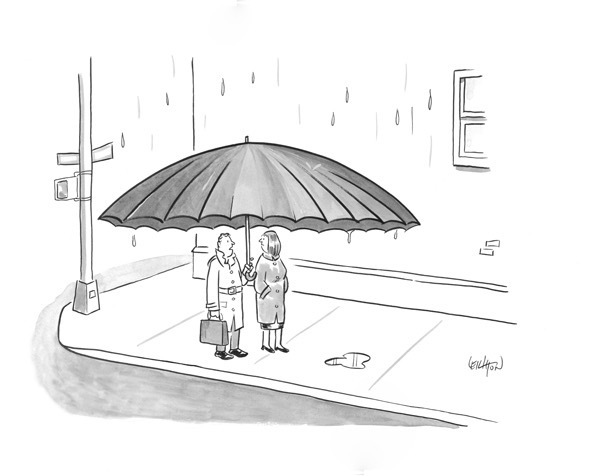

In [21]:
dataset[10]['image']

In [24]:
dataset[10]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=600x476>,
 'contest_number': 521,
 'image_location': 'the sidewalk',
 'image_description': 'A couple is walking in the rain. The man is carrying a huge umbrella that dwarfs both of them.',
 'image_uncanny_description': "The man's umbrella is absurdly huge.",
 'entities': ['https://en.wikipedia.org/wiki/Umbrella',
  'https://en.wikipedia.org/wiki/Rain'],
 'questions': ["Why is the man's umbrella so huge?"],
 'caption_choices': "Check to see if it's still raining.",
 'from_description': "scene: the sidewalk description: A couple is walking in the rain. The man is carrying a huge umbrella that dwarfs both of them. uncanny: The man's umbrella is absurdly huge. entities: Umbrella, Rain. caption: Check to see if it's still raining.",
 'label': "The umbrella is so big that the people holding it can't tell if it's raining or not because they are physically so far from the edge of the umbrella, which would make it hard to see that f

In [152]:
import matplotlib.pyplot as plt

def display_images(index_list, dataset, num_images_per_row=4):
    best_captions_dict = get_best_captions(index_list)
    num_images = len(index_list)
    num_rows = (num_images + num_images_per_row - 1) // num_images_per_row
    
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 15))
    
    for i, idx in enumerate(index_list):
        row = i // num_images_per_row
        col = i % num_images_per_row
        ax = axes[row, col] if num_rows > 1 else axes[col]
        
        # Plot the image
        ax.imshow(dataset[idx]['image'], cmap='gray')  # Specify the colormap as 'gray'
        ax.axis('off')
        
        # Get the caption for the current index
        models = list(best_captions_dict.keys())
        model_text = '\n'.join([f"{model}: {best_captions_dict[model][i]}" for model in models])
        print(best_captions_dict[models[0]])
        
        # Display text underneath the image
        ax.text(0, -0.1, model_text, transform=ax.transAxes, ha='left', va='top', fontsize=10)
    
    # Hide any empty subplots
    for i in range(len(index_list), num_rows * num_images_per_row):
        row = i // num_images_per_row
        col = i % num_images_per_row
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()


['sasquatch', 'a cartoon of a man in a wheelchair being helped by a nurse', 'a man and woman are standing under an umbrella', 'a man is sitting in a chair and a woman is sitting on the couch', 'a cartoon dog and sheep in a field', 'a man is sitting in bed with a dog']
['sasquatch', 'a cartoon of a man in a wheelchair being helped by a nurse', 'a man and woman are standing under an umbrella', 'a man is sitting in a chair and a woman is sitting on the couch', 'a cartoon dog and sheep in a field', 'a man is sitting in bed with a dog']
['sasquatch', 'a cartoon of a man in a wheelchair being helped by a nurse', 'a man and woman are standing under an umbrella', 'a man is sitting in a chair and a woman is sitting on the couch', 'a cartoon dog and sheep in a field', 'a man is sitting in bed with a dog']
['sasquatch', 'a cartoon of a man in a wheelchair being helped by a nurse', 'a man and woman are standing under an umbrella', 'a man is sitting in a chair and a woman is sitting on the couch', 

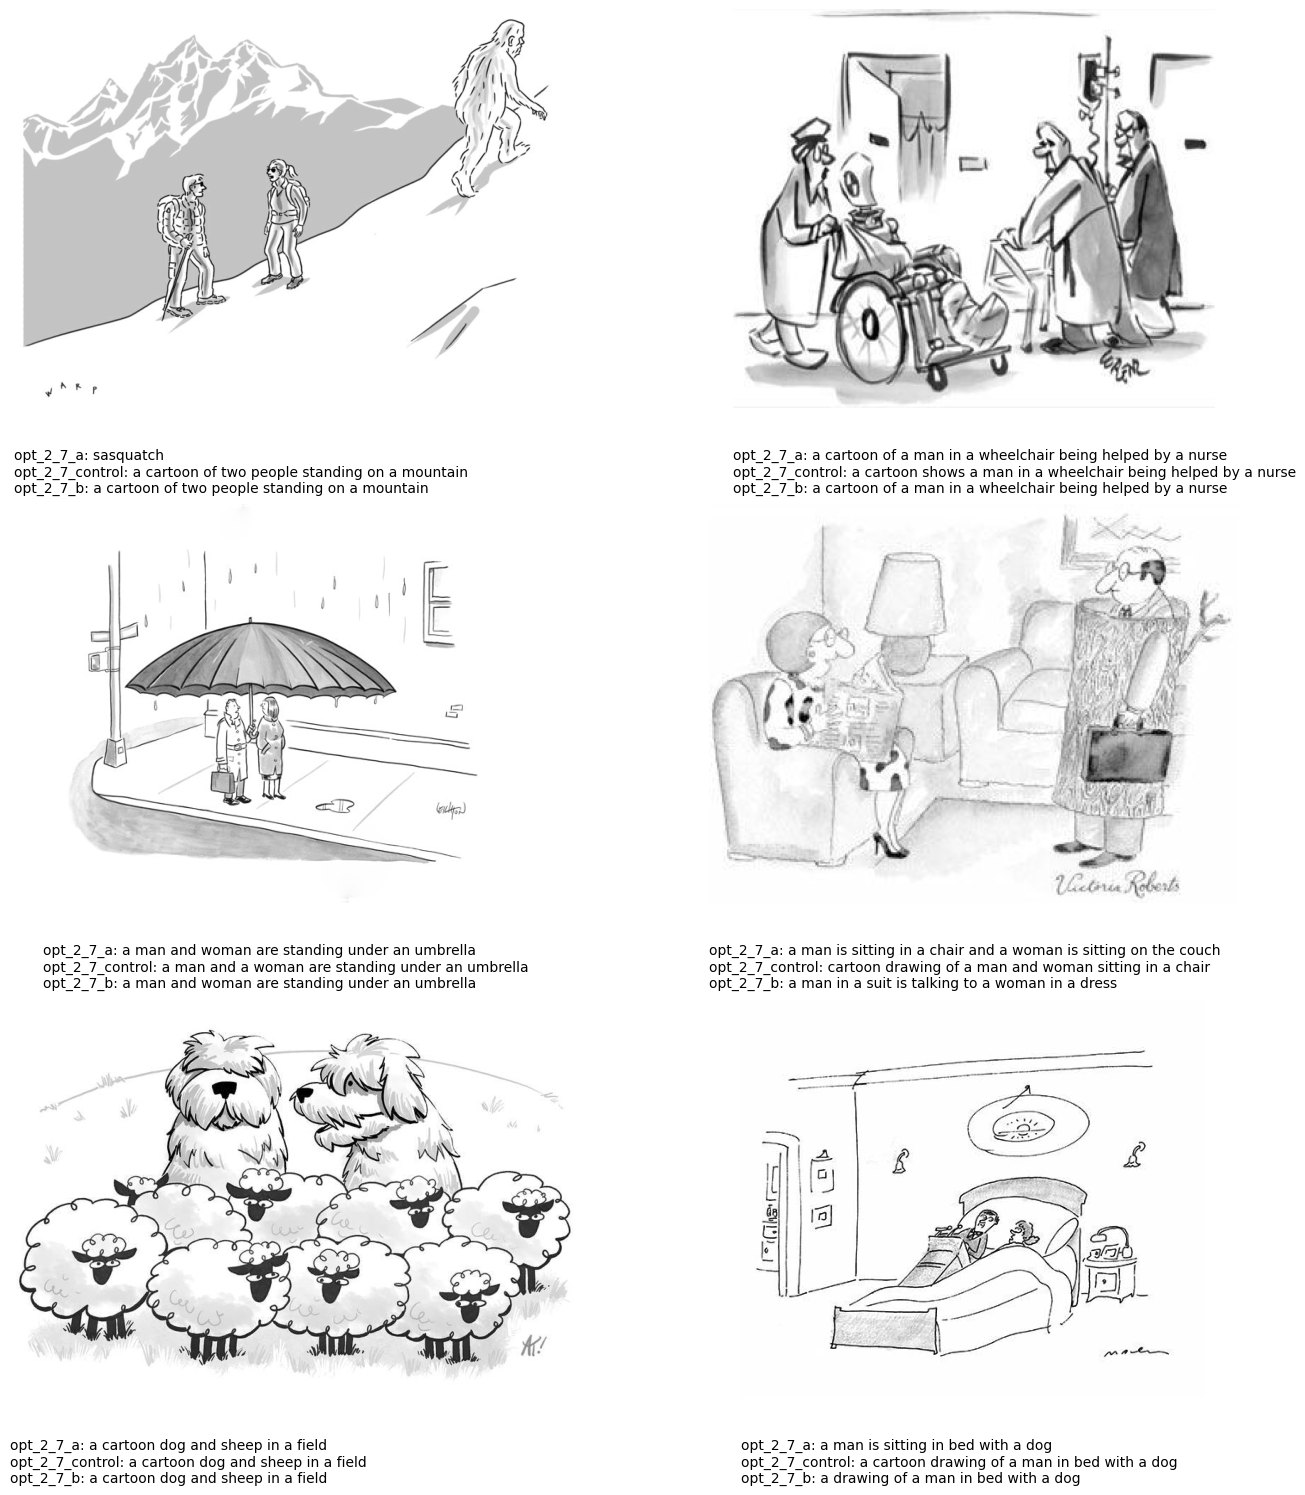

In [156]:
display_images([0, 4, 10, 23, 30, 41], dataset, num_images_per_row=2)